# Training 

In this part we will show how to train a network on one of our model problems: TSA problem. 

The description of the problem to non-russian speakers: it roughly corresponds to a "s" ending in English in 3rd person singular verb form. Compare:

1. He like**s** it.

2. He should like it.

In the sentence 1, "to like" is in finite form (3rd person singular) and must accept "s" ending. In the sentence 2, "to like" is infinitive form and accepts to ending. In Russian language, these two sentences are as follows:

1. Ему это нрави**тся**.

2. Ему должно это нрави**ться**.

So the TSA problem is: given a russian sentence that contains a word with "тся" or "ться" (both pronounces as "tsa", hence the problem's name), determine if the word is in the correct form. The model should explore the grammar of the surrounding words and make an educated guess. In English, for instance, if the verb immediately follows a noun or pronoun, it is _probably_ in the finite form. If instead it follows the modal verb (such as "should"), it is _probably_ in the infinitive form. 


## TG

Training Grounds is a open-source library written in [Outfittery GMBH](http://outfittery.de) to prepare the entangled tabular data for neural networks. It is used intensively in `grammar_ru`.

## Dataset

Solving of any problem in `grammar_ru` starts with dataset: a bundle that contains all the data needed to solve the task (including label). For TSA task, the approach is to get the texts with relatively few errors (newpapers, books, etc), then replace the correct form with incorrect forms and keep labels of whether the replacement took place for the particilar sentence in the bundle.

This part is a routine data processing and not that exciting, so it is covered in a separate demo. Right now, le'ts assume someone just gave us the appropriate bundle.

In [1]:
from tg.common import DataBundle, Loc

db = DataBundle.load('files/tsa-test.zip')

In comparison with previous bundles, dataset contains an `index` frame. Index contains _samples_. In TSA task, one sample corresponds to a -tsa ending verb in correct or incorrect form in the dataset. The samples could also be sentences, or pair of words, of whatever. So Index is an addition to the normal NLP bundle that describes not the text itself, but a problem about this text that we try to solve.

In [2]:
db.index.head()

,word_id,sentence_id,label,split
sample_id,,,,
3,3,0,0,train
21,21,1,0,train
39,39,2,0,display
45,45,3,0,train
76,76,73,1,test


Other frames in `db` are familiar:

In [3]:
db.src.head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,—,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,68,4,2,False
1,1,0,1,0,1,Фильм,ru,5,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,69,4,2,False
2,2,0,2,0,0,«,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,70,4,2,False
3,3,0,3,0,0,Растворяться,ru,12,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,True,0,pub.base.zip,71,4,2,False
4,4,0,4,0,1,»,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,0,pub.base.zip,72,4,2,False


Since the dataset is typically obtained by merging subsets of several corpora, it carries additional information that can be used to trace the original sentences in the corpora.

Other dataframes are unchanged:

In [4]:
db['pymorphy'].head()

,normal_form,alternatives,score,delta_score,POS,animacy,gender,number,case,aspect,transitivity,person,tense,mood,voice,involvement
word_id,,,,,,,,,,,,,,,,
0,—,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None
1,фильм,2,0.623076,0.246153,NOUN,inan,masc,sing,nomn,None,None,None,None,None,None,None
2,«,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None
3,растворяться,1,1.000000,1.000000,INFN,None,None,None,None,impf,intr,None,None,None,None,None
4,»,1,1.000000,1.000000,NONE,None,None,None,None,None,None,None,None,None,None,None


In [5]:
db['slovnet'].head()

,POS,Animacy,Case,Gender,Number,Aspect,Mood,Person,Tense,VerbForm,Voice,Degree,Variant,Polarity,Foreign,relation,syntax_parent_id
word_id,,,,,,,,,,,,,,,,,
0,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,5
1,NOUN,Inan,Nom,Masc,Sing,None,None,None,None,None,None,None,None,None,None,nsubj,5
2,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,3
3,NOUN,Inan,Nom,Masc,Plur,None,None,None,None,None,None,None,None,None,None,appos,1
4,PUNCT,None,None,None,None,None,None,None,None,None,None,None,None,None,None,punct,3


When training, we use `IndexedDataBundle` instead of `DataBundle`. `IndexedDataBundle` contains the bundle itself, plus it's index or a subset of the index that is important on this or that stage of the training. Let's create an `IndexedDataBundle` for the rest of the demonstration. It will only contain 5 samples:

In [6]:
from tg.common.ml import batched_training as bt

idb = bt.IndexedDataBundle(
    index_frame = db.index.loc[db.index.split=='train'].sample(5, random_state=45), 
    bundle = db
)
idb.index_frame



,word_id,sentence_id,label,split
sample_id,,,,
17017,17017,16998,0,train
61984,61984,61970,1,train
49770,49770,49763,1,train
28257,28257,28257,1,train
16689,16689,16680,1,train


With the usage of `Separator.Viewer`, let's preview the selected sentences:

In [37]:
from tg.grammar_ru import Separator
import numpy as np

def represent(index, src):
    df = src
    df = df.loc[df.sentence_id.isin(idb.index_frame.sentence_id)].copy()
    df = df.merge(
        index.reset_index().set_index('sentence_id')[['sample_id']], 
        left_on='sentence_id', 
        right_index=True
    )
    df['mark'] = np.where(df.is_target, df.label.astype(str), 'no')
    return df
    return Separator.Viewer().tooltip('sample_id').highlight('mark', {'1':'#ffaaaa', '0':'#aaffaa'}).to_html_display(df)


represent(idb.index_frame, idb.bundle.src)


,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated,sample_id,mark
16680,16680,16680,0,16680,1,Будет,ru,5,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,10407204,10407065,10407058,False,16689,no
16681,16681,16680,1,16680,1,очень,ru,5,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,10407205,10407065,10407058,False,16689,no
16682,16682,16680,2,16680,0,жаль,ru,4,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,10407206,10407065,10407058,False,16689,no
16683,16683,16680,3,16680,1,",",punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,10407207,10407065,10407058,False,16689,no
16684,16684,16680,4,16680,1,если,ru,4,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,10407208,10407065,10407058,False,16689,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61986,61986,61970,16,61970,1,могу,ru,4,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,35548231,35548059,35548047,False,61984,no
61987,61987,61970,17,61970,0,(,punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,35548232,35548059,35548047,False,61984,no
61988,61988,61970,18,61970,0,вздыхает,ru,8,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,35548233,35548059,35548047,False,61984,no
61989,61989,61970,19,61970,0,),punct,1,273a88ef-0d47-4a69-8c84-9b91e2d5427f,transfuzed.zip,False,1,pub.base.zip,35548234,35548059,35548047,False,61984,no


## Features

The  first major milestone of the training is preparing features in the format that can be consumed by a neural network. Right now, the features are distributed across different dataframes, some of them are not even required, some in categorical format. 

For NLP task, there is usually an additional context problem: we cannot solve the TSA task just by looking at the features of the word-in-question. Instead, for each sample we must build a set of words _around_ the word-in-question, and then use all their features to make the prediction.

Our approach is as follows:

* The dataset is consumed by training as is, so, as the set of dataframes
* The samples are separated into groups, and for each group we perform _extraction_
  * contexts are built
  * data frames are merged appropriately, redundant columns are removed
  * continious features are normalized, categorical features are converted encoded by one-hot
* The result of the extraction we call batch. They are as big as the memory can handle, e.g. 50000 samples.
* The batches are subdivided into mini-batches and then consumed by a network

Why don't we want to precompute batches beforehand?

* They would have an immense size
* We would need to run the precomputation even for the slightest changes of the dataset, e.g., if we decide not to use certain features, but logically, this hyperparameter belongs to the model, not to the dataset.
* Comparing with training, batching doesn't take so long, so we can sacrifice this CPU time for memory saving and comfort.

If needed, all the machinery, described below, can be used to split this processes: first we would run all the extractor, create all the batches and store them; and second, run the network.


### Extractor

First, let's collect the features for one word. This can be done by `PlainExtractor`:

In [8]:
from tg.common.ml import dft

p_extractor = (bt
             .PlainExtractor
             .build('pymorphy')
             .index()
             .join('pymorphy', on_columns='word_id')
             .apply(
                 transformer=dft.DataFrameTransformerFactory.default_factory(),
                 drop_columns=['normal_form', 'alternatives']
             ))
p_extractor.fit_extract(idb)

,score,delta_score,POS_INFN,POS_VERB,animacy_NULL,gender_NULL,number_plur,number_NULL,case_NULL,aspect_perf,aspect_impf,transitivity_intr,person_3per,person_NULL,tense_futr,tense_NULL,mood_indc,mood_NULL,voice_NULL,involvement_NULL
sample_id,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
61984,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
49770,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
28257,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
16689,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0


We used FluentAPI design pattern that explains what is going to happen: `index()` is going to be joined with `pymorphy` frame in the bundle on `word_id` column, then we will `drop_columns` of normal form and alternatives, and apply `dft.DataFrameTransformerFactory.default_factory()`. The later is a universal solution that deals with normalization and one-hot encoding. Please read TG documentation and demos for details. The main feature of this class is that it wraps `scikit-learn` transformers, but keep the columns' names for traceability.

We can build an extractor for `slovnet` as well:

In [9]:
s_extractor = (bt
             .PlainExtractor
             .build('slovnet')
             .index()
             .join('slovnet', on_columns='word_id')
             .apply(
                 transformer=dft.DataFrameTransformerFactory.default_factory(),
                 drop_columns=['syntax_parent_id']
             ))
s_extractor.fit_extract(idb)

,POS_VERB,Animacy_NULL,Case_NULL,Gender_Neut,Gender_NULL,Number_Plur,Number_Sing,Number_NULL,Aspect_Perf,Aspect_Imp,...,Voice_Pass,Degree_NULL,Variant_NULL,Polarity_NULL,Foreign_NULL,relation_advcl,relation_csubj,relation_nsubj,relation_root,relation_xcomp
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
61984,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
49770,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
28257,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
16689,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


There is no particular reason why those two must be separate, so, we will unite them into one:

In [10]:
extractor = bt.CombinedExtractor(name = 'features', extractors = [p_extractor, s_extractor])
extractor.fit_extract(idb)

,pymorphy_score,pymorphy_delta_score,pymorphy_POS_INFN,pymorphy_POS_VERB,pymorphy_animacy_NULL,pymorphy_gender_NULL,pymorphy_number_plur,pymorphy_number_NULL,pymorphy_case_NULL,pymorphy_aspect_perf,...,slovnet_Voice_Pass,slovnet_Degree_NULL,slovnet_Variant_NULL,slovnet_Polarity_NULL,slovnet_Foreign_NULL,slovnet_relation_advcl,slovnet_relation_csubj,slovnet_relation_nsubj,slovnet_relation_root,slovnet_relation_xcomp
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
61984,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
49770,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
28257,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
16689,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


`PlainExtractor` and `CombinedExtractor` are the classes from TG. `grammar_ru` offers `CoreExtractor` that incapsulates all the necessary functionality for extracting:

In [11]:
from tg.grammar_ru.components import CoreExtractor

extractor = CoreExtractor(name = 'features')
extractor.fit_extract(idb)

2023-02-04 13:44:40.656153 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-04 13:44:40.708406 INFO: Success
2023-02-04 13:44:40.709643 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-04 13:44:40.739605 INFO: Success
2023-02-04 13:44:40.740446 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-04 13:44:40.756061 INFO: Success
2023-02-04 13:44:40.757346 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-04 13:44:40.777748 INFO: Success
2023-02-04 13:44:40.778518 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-04 13:44:40.821770 INFO: Success


,pymorphy_score,pymorphy_delta_score,pymorphy_alternatives,pymorphy_POS_INFN,pymorphy_POS_VERB,pymorphy_animacy_NULL,pymorphy_gender_NULL,pymorphy_number_plur,pymorphy_number_NULL,pymorphy_case_NULL,...,syntax_fixes_root_No,syntax_fixes_root_Good,syntax_fixes_cycle_status_No,syntax_fixes_cycle_status_Broken,syntax_stats_descendants_relative,syntax_stats_children,syntax_stats_descendants,syntax_stats_sentence_length,syntax_stats_up_depth,syntax_stats_down_depth
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,-0.834075,-0.430448,-0.538925,0.973343,1.282837,-0.173489
61984,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,-0.967527,-1.422299,-1.246667,0.973343,0.892327,-1.656397
49770,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.634787,1.141598,1.447958,0.065983,-1.533745,1.309419
28257,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,-0.500445,-0.430448,-0.538925,-1.739627,-0.320709,-0.173489
16689,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.667260,1.141598,0.876559,-0.273041,-0.320709,0.693956


### Contexts

As mentioned before, the features of the word itself are not sufficient to solve the problem. So, we will build a _context_ for each sample: the set of the words words relevant to the word in question.

Contexts are common not only in NLP. For instance in sales data there are lots of different contexts, for instance:

* Financial performance of the previous orders of the customer
* The history of returns of the individual articles in the past

Generally, all the situations when multiple entities are associated with a sample and the sample should be therefore transformed into 3-dimentional tensors, are covered by contexts. Theoretically, 4-th dimentioal contexts are possible with the provided machinery as well, but they were never used in practice.

First, let's create a context's index:

In [12]:
from tg.grammar_ru.components import PlainContextBuilder

context_builder = PlainContextBuilder(
    include_zero_offset=True,
    left_to_right_contexts_proportion=0.5
)

context_df = context_builder.build_context(idb, 5).sort_index()
context_df

another_word_id
sample_id offset                 
16689     -2                16687
          -1                16688
           0                16689
           1                16690
           2                16691
17017     -2                17015
          -1                17016
           0                17017
           1                17018
28257      0                28257
           1                28258
           2                28259
49770     -2                49768
          -1                49769
           0                49770
           1                49771
           2                49772
61984     -2                61982
          -1                61983
           0                61984
           1                61985
           2                61986

The index now contain `offset` column, which is 

Now, the trick. The extractors we defined above accept `IndexedDataBundle`, and then use its `index_frame` as the departing point for joining. So, for the extractors in the context, we will simply replace `index_frame` with `context_df` and apply the same `CoreExtractor`: 

In [13]:
tdb = idb.change_index(context_df)
extractor = CoreExtractor(name = 'features', join_column='another_word_id')
extractor.fit_extract(tdb)

2023-02-04 13:44:41.110563 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-04 13:44:41.184633 INFO: Success
2023-02-04 13:44:41.185489 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-04 13:44:41.225689 INFO: Success
2023-02-04 13:44:41.226397 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-04 13:44:41.239057 INFO: Success
2023-02-04 13:44:41.240883 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-04 13:44:41.257517 INFO: Success
2023-02-04 13:44:41.259167 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-04 13:44:41.317777 INFO: Success


pymorphy_score  pymorphy_delta_score  pymorphy_alternatives  \
sample_id offset                                                                
16689     -2            0.555949              0.566548              -0.573317   
          -1           -2.705916             -2.687135               0.796750   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2            0.555949              0.566548              -0.573317   
17017     -2            0.555949              0.566548              -0.573317   
          -1            0.555949              0.566548              -0.573317   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
28257      0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2           -1.116806             -0.935154               1.237812   
49770     -2           -2.380909             -2.273104               1.237812   
          -1           -0.812164             -1.071067               0.228121   
           0            0.555949              0.566548              -0.573317   
           1            0.552290              0.563548               3.272946   
           2           -0.489522             -0.684868               0.228121   
61984     -2           -1.386209             -1.410436               1.598187   
          -1            0.555949              0.566548              -0.573317   
           0            0.555949              0.566548              -0.573317   
           1            0.555949              0.566548              -0.573317   
           2            0.555949              0.566548              -0.573317   

                  pymorphy_POS_INFN  pymorphy_POS_NONE  pymorphy_POS_NOUN  \
sample_id offset                                                            
16689     -2                    0.0                0.0                1.0   
          -1                    0.0                0.0                0.0   
           0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
           2                    0.0                1.0                0.0   
17017     -2                    0.0                0.0                0.0   
          -1                    0.0                0.0                0.0   
           0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
28257      0                    1.0                0.0                0.0   
           1                    0.0                1.0                0.0   
           2                    0.0                0.0                0.0   
49770     -2                    0.0                0.0                0.0   
          -1                    0.0                0.0                1.0   
           0                    1.0                0.0                0.0   
           1                    0.0                0.0                0.0   
           2                    0.0                0.0                0.0   
61984     -2                    0.0                0.0                1.0   
          -1                    0.0                0.0                0.0   
           0                    0.0                0.0                0.0   
           1                    0.0                0.0                0.0   
           2                    0.0                0.0                0.0   

                  pymorphy_POS_VERB  pymorphy_POS_ADJF  pymorphy_POS_ADVB  \
sample_id offset                                                            
16689     -2                    0.0                0.0                

But the dimentions of these features are misaligned: the network expects one sample per row, while currently we have several rows per sample. Some postprocessing is needed to align the axes:

### Assembly Point

The final alignment of the axes is bound with the network we are going to use. For instance, LSTM network would require 3-dimentional tensor; another (although less performant) option is to pivot the dataframe over `offset`, create 2-dimentional tensor and feed it to the simple fully-connected network. So network structure and the alignment (which we call _aggregation_) are paired, and this is represented by `ContextualAssemplyPoint` class.

We only take `POS` column from pymorphy to make the output readable. Here, a pivoting option:

In [14]:
from tg.common.ml.batched_training import context as btc

ap_test = btc.ContextualAssemblyPoint(
    name = 'features',
    context_builder = context_builder,
    extractor = bt.PlainExtractor.build('features').index().join('pymorphy','another_word_id').apply(
        transformer=dft.DataFrameTransformerFactory.default_factory(),
        take_columns=['POS']
    ),
    context_length=5
)
ap_test.reduction_type = btc.ReductionType.Pivot
qdf = ap_test.create_extractor().fit_extract(idb)
qdf

,f0a0_POS_ADJF_at_-2,f0a0_POS_ADJF_at_-1,f0a0_POS_ADJF_at_0,f0a0_POS_ADJF_at_1,f0a0_POS_ADJF_at_2,f0a0_POS_ADVB_at_-2,f0a0_POS_ADVB_at_-1,f0a0_POS_ADVB_at_0,f0a0_POS_ADVB_at_1,f0a0_POS_ADVB_at_2,...,f0a0_POS_VERB_at_-1,f0a0_POS_VERB_at_0,f0a0_POS_VERB_at_1,f0a0_POS_VERB_at_2,f0a0_offset_is_presenting_at_-2,f0a0_offset_is_presenting_at_-1,f0a0_offset_is_presenting_at_0,f0a0_offset_is_presenting_at_1,f0a0_offset_is_presenting_at_2,f0a0_present_f0a0
sample_id,,,,,,,,,,,,,,,,,,,,,
17017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1
61984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
49770,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1
28257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
16689,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1


For better readability:

In [15]:
qdf[[c for c in qdf.columns if 'POS_VERB' in c]]

,f0a0_POS_VERB_at_-2,f0a0_POS_VERB_at_-1,f0a0_POS_VERB_at_0,f0a0_POS_VERB_at_1,f0a0_POS_VERB_at_2
sample_id,,,,,
17017,0.0,1.0,0.0,0.0,0.0
61984,0.0,0.0,1.0,0.0,1.0
49770,0.0,0.0,0.0,0.0,0.0
28257,0.0,0.0,0.0,0.0,0.0
16689,0.0,0.0,0.0,0.0,0.0


Now, let's demonstrate 3-dimentional tensors:

In [16]:
ap_test.reduction_type = btc.ReductionType.Dim3
tn = ap_test.create_extractor().fit_extract(idb)
tn

In [17]:
{k:v for k,v in zip(tn.dim_names, tn.dim_indices)}

{'offset': [-2, -1, 0, 1, 2],
 'sample_id': [17017, 61984, 49770, 28257, 16689],
 'features': ['POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP']}

We still want to maintain the column names here, so `AnnotatedTensor` is introduced.

We also have folded option, that has proven to be the most effective for TSA problem and similar:

In [18]:
ap_test.reduction_type = btc.ReductionType.Dim3Folded
tn = ap_test.create_extractor().fit_extract(idb)
{k:v for k,v in zip(tn.dim_names, tn.dim_indices)}

{'offset': [-2, -1, 0],
 'sample_id': [17017, 61984, 49770, 28257, 16689],
 'features': ['POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP',
  'POS_INFN',
  'POS_NONE',
  'POS_NOUN',
  'POS_VERB',
  'POS_ADJF',
  'POS_ADVB',
  'POS_NPRO',
  'POS_PRCL',
  'POS_PREP']}

**Future notes**: There are some problems with the current implementation of Dim3Folded:

- requires odd context length and left_to_right_contexts_proportion=0.5
- naming is imperfect

### Batch


Now we are ready to create a batch:

In [19]:
def create_assembly_point(context_length = 5):
    ap = btc.ContextualAssemblyPoint(
        name = 'features',
        context_builder = context_builder,
        extractor = CoreExtractor(join_column='another_word_id'),
        context_length=5
    )
    ap.reduction_type = ap.reduction_type.Dim3Folded
    return ap

create_assembly_point().create_extractor().fit_extract(idb)

2023-02-04 13:44:42.306446 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-04 13:44:42.339383 INFO: Success
2023-02-04 13:44:42.340681 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-04 13:44:42.397655 INFO: Success
2023-02-04 13:44:42.399355 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-04 13:44:42.410896 INFO: Success
2023-02-04 13:44:42.412396 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-04 13:44:42.434923 INFO: Success
2023-02-04 13:44:42.436178 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-04 13:44:42.497284 INFO: Success


Aside from features, we will also need labels. Those can be taken from `index_frame` directly, and no transformer is needed:

In [20]:
from tg.common.ml.batched_training import factories as btf

def create_label_extractor():
    label_extractor = bt.PlainExtractor.build(btf.Conventions.LabelFrame).index().apply(take_columns='label')
    return label_extractor

create_label_extractor().extract(idb)

,label
sample_id,
17017,0
61984,1
49770,1
28257,1
16689,1


In [21]:
batcher = bt.Batcher([create_assembly_point().create_extractor(), create_label_extractor()])
batch = batcher.fit_extract(3, idb)

2023-02-04 13:44:42.978287 INFO: Fitting extractor pymorphy in CoreExtractor
2023-02-04 13:44:43.032043 INFO: Success
2023-02-04 13:44:43.032793 INFO: Fitting extractor slovnet_morph in CoreExtractor
2023-02-04 13:44:43.063022 INFO: Success
2023-02-04 13:44:43.063791 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2023-02-04 13:44:43.084952 INFO: Success
2023-02-04 13:44:43.085852 INFO: Fitting extractor syntax_fixes in CoreExtractor
2023-02-04 13:44:43.097465 INFO: Success
2023-02-04 13:44:43.098704 INFO: Fitting extractor syntax_stats in CoreExtractor
2023-02-04 13:44:43.143051 INFO: Success


In [22]:
batch.index_frame

,word_id,sentence_id,label,split
sample_id,,,,
17017,17017,16998,0,train
61984,61984,61970,1,train
49770,49770,49763,1,train


In [23]:
batch.bundle

{'features': 'AnnotatedTensor', 'label': {'shape': (3, 1), 'index_name': 'sample_id'}}

## Network

- Gorynych network

### Smplest approach

In [24]:
ap = create_assembly_point()
ap.hidden_size = 50
ap.dim_3_network_factory.network_type = btc.Dim3NetworkType.LSTM
head_factory = ap.create_network_factory()
head = head_factory(batch)
head(batch)

tensor([[ 0.1463,  0.0666,  0.2300,  0.2299,  0.0955, -0.1558, -0.0900, -0.1428,
          0.0933,  0.3418, -0.0107, -0.1559,  0.1074, -0.0073, -0.0893,  0.0566,
         -0.0626, -0.0923, -0.2129,  0.1991,  0.2372, -0.1160, -0.0481,  0.3732,
         -0.0817, -0.0316,  0.2756, -0.3245, -0.1187, -0.1890,  0.2385,  0.2198,
          0.0342, -0.0688,  0.0122,  0.0776,  0.0796,  0.0295, -0.0609,  0.3557,
         -0.0105,  0.4281, -0.0363,  0.0344, -0.2836, -0.1109, -0.0932, -0.3532,
          0.0174, -0.1295],
        [ 0.0594,  0.2778,  0.4297,  0.3624,  0.0686, -0.1061, -0.2166,  0.0272,
         -0.1791,  0.1327, -0.0396, -0.1885,  0.2832, -0.0856,  0.0329,  0.1912,
          0.0213, -0.1209, -0.3182,  0.2718, -0.0323,  0.0204, -0.0466,  0.2056,
         -0.2939, -0.0677, -0.1853, -0.4379, -0.0886, -0.1753,  0.1137,  0.0827,
          0.0057, -0.0728, -0.0087,  0.0313,  0.0026, -0.0246, -0.2050,  0.3317,
         -0.0929,  0.2840,  0.0209, -0.0023, -0.3845, -0.1420, -0.0741,  0.1087,


In [25]:
head(batch).shape

torch.Size([3, 50])

Why do we need batch here? Because the number of features varies

- this image from OF presentation

In [26]:
import torch

class Network(torch.nn.Module):
    def __init__(self, head, hidden_size):
        super(Network, self).__init__()
        self.head = head
        self.tail = btf.Perceptron(hidden_size, 1)
        
    def forward(self, batch):
        return self.tail(self.head(batch))
    
network = Network(head, ap.hidden_size)
network(batch)

tensor([[0.5474],
        [0.5298],
        [0.5156]], grad_fn=<SigmoidBackward0>)

### Advanced approach

In [27]:

class Network(torch.nn.Module):
    def __init__(self, head, hidden_size):
        super(Network, self).__init__()
        self.head = head
        self.tail = btf.Perceptron(hidden_size, 1)
        
    def forward(self, batch):
        return self.tail(self.head(batch))
    
    class Factory:
        def __init__(self, head_factory):
            self.head_factory = head_factory
            
        def __call__(self, batch):
            head = self.head_factory(batch)
            hidden_size = head(batch).shape[1]
            return Network(head, hidden_size)
            
            
        
    
network = Network(head, ap.hidden_size)
network(batch)

tensor([[0.5431],
        [0.5174],
        [0.4884]], grad_fn=<SigmoidBackward0>)

In [28]:

class Network(torch.nn.Module):
    def __init__(self, head, hidden_size):
        super(Network, self).__init__()
        self.head = head
        self.tail = btf.Perceptron(hidden_size, 1)
        
    def forward(self, batch):
        return self.tail(self.head(batch))
    
    class Factory:
        def __init__(self, head_factory):
            self.head_factory = head_factory
            
        def __call__(self, batch):
            head = self.head_factory(batch)
            intermediate_tensor = head(batch)
            return Network(head, intermediate_tensor)
            
            
        
    
network = Network(head, ap.hidden_size)
network(batch)

tensor([[0.5656],
        [0.5634],
        [0.5491]], grad_fn=<SigmoidBackward0>)

In [29]:
from functools import partial

factory = btf.FeedForwardNetwork.Factory(
    ap.create_network_factory(),
    partial(btf.Perceptron, output_size = 1)
)
network = factory(batch)
network(batch)

tensor([[0.4894],
        [0.5077],
        [0.4964]], grad_fn=<SigmoidBackward0>)

In [30]:
## Training task

2023-02-04 13:44:44.076111 INFO: Training starts. Info: {}
2023-02-04 13:44:44.077680 INFO: Ensuring/loading bundle. Bundle before:
{'index': {'shape': (2144, 4), 'index_name': 'sample_id'}, 'slovnet': {'shape': (49990, 17), 'index_name': 'word_id'}, 'syntax_closure': {'shape': (128382, 4), 'index_name': 'entry_id'}, 'syntax_fixes': {'shape': (49990, 4), 'index_name': 'word_id'}, 'syntax_stats': {'shape': (49990, 6), 'index_name': 'word_id'}, 'pymorphy': {'shape': (49990, 16), 'index_name': 'word_id'}, 'src': {'shape': (49990, 17), 'index_name': None}}
2023-02-04 13:44:44.078549 INFO: Bundle loaded
{'index': {'shape': (2144, 4), 'index_name': 'sample_id', 'columns': ['word_id', 'sentence_id', 'label', 'split'], 'index': [3, 21, 39, 45, 76, '...']}, 'slovnet': {'shape': (49990, 17), 'index_name': 'word_id', 'columns': ['POS', 'Animacy', 'Case', 'Gender', 'Number', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'syntax_closure': {'shape': (128382, 4), 'index_name': 'entry_id', 'columns': ['wo

2023-02-04 13:45:00.018205 INFO: ###loss:0.23092007171362638
2023-02-04 13:45:00.019103 INFO: ###iteration:7
2023-02-04 13:45:00.019986 INFO: Epoch 8 of 10
2023-02-04 13:45:00.578801 INFO: Training: 0/1 batch, 0/4 mini-epoch
2023-02-04 13:45:00.690364 INFO: Training: 0/1 batch, 1/4 mini-epoch
2023-02-04 13:45:00.838889 INFO: Training: 0/1 batch, 2/4 mini-epoch
2023-02-04 13:45:01.030687 INFO: Training: 0/1 batch, 3/4 mini-epoch
2023-02-04 13:45:01.214949 INFO: test: 0/1
2023-02-04 13:45:01.615445 INFO: display: 0/1
2023-02-04 13:45:01.958783 INFO: ###roc_auc_score_test:0.6933486482051678
2023-02-04 13:45:01.959661 INFO: ###roc_auc_score_display:0.7427031316533117
2023-02-04 13:45:01.960259 INFO: ###loss:0.22683429159224033
2023-02-04 13:45:01.960845 INFO: ###iteration:8
2023-02-04 13:45:01.968776 INFO: Epoch 9 of 10
2023-02-04 13:45:02.417866 INFO: Training: 0/1 batch, 0/4 mini-epoch
2023-02-04 13:45:02.509603 INFO: Training: 0/1 batch, 1/4 mini-epoch
2023-02-04 13:45:02.600143 INFO: T

<AxesSubplot: >

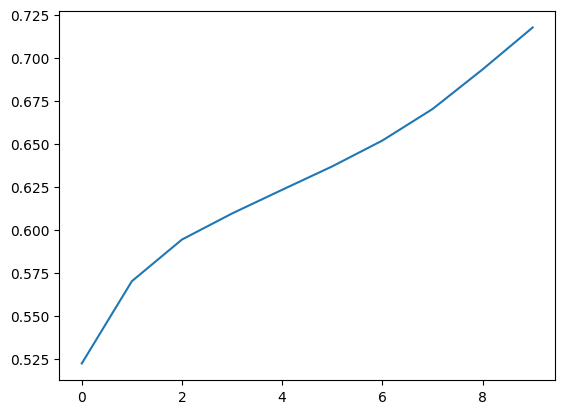

In [31]:
from sklearn.metrics import roc_auc_score
import pandas as pd

class TrainingTask(btf.TorchTrainingTask):
    def __init__(self):
        super(TrainingTask, self).__init__()
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.features_ap = create_assembly_point()
    
    def initialize_task(self, idb):
        self.setup_batcher(idb, [ap.create_extractor(), create_label_extractor()])
        self.setup_model(factory, ignore_consistancy_check=True)
        
task = TrainingTask()
task.settings.epoch_count=10
result = task.run(db)
pd.DataFrame(result['output']['history']).roc_auc_score_test.plot()